In [1]:
import time
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (roc_auc_score, f1_score, roc_curve, auc, 
                             confusion_matrix, precision_recall_curve, make_scorer)




In [2]:
from utils import utils

# Functions and configurations

In [3]:
RANDOM_STATE = 35

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Processing data

In [4]:
data_raw = pd.read_csv("dataset/processed_features.csv")


In [5]:
data_raw.corr()

,account_id,device_id,balance,processed_at,is_fraud,age_range,number_of_selfies_sent,time_client,cash_out_type_1,cash_out_type_2,cash_out_type_3,cash_out_type_6
account_id,1.000000,0.936605,-0.115446,0.030805,-0.031733,0.014728,-0.011119,-0.124930,-0.024468,0.314274,-0.312839,0.001893
device_id,0.936605,1.000000,-0.120909,0.030237,-0.032270,0.010916,-0.010421,-0.128533,-0.021081,0.339309,-0.339272,0.001675
balance,-0.115446,-0.120909,1.000000,0.013672,-0.002463,0.041070,-0.015854,0.278847,0.019471,0.036898,-0.043073,-0.000271
processed_at,0.030805,0.030237,0.013672,1.000000,-0.006212,0.005170,-0.010542,0.034895,-0.000934,0.011392,-0.011319,-0.001043
is_fraud,-0.031733,-0.032270,-0.002463,-0.006212,1.000000,0.001232,0.000773,-0.001799,0.005346,0.017931,-0.019762,-0.000132
age_range,0.014728,0.010916,0.041070,0.005170,0.001232,1.000000,-0.008867,-0.025235,0.002038,0.043571,-0.044924,0.001572
number_of_selfies_sent,-0.011119,-0.010421,-0.015854,-0.010542,0.000773,-0.008867,1.000000,0.134589,0.006826,-0.008444,0.006654,-0.000253
time_client,-0.124930,-0.128533,0.278847,0.034895,-0.001799,-0.025235,0.134589,1.000000,0.014227,-0.022264,0.018509,0.014154
cash_out_type_1,-0.024468,-0.021081,0.019471,-0.000934,0.005346,0.002038,0.006826,0.014227,1.000000,-0.200642,-0.079909,-0.000421
cash_out_type_2,0.314274,0.339309,0.036898,0.011392,0.017931,0.043571,-0.008444,-0.022264,-0.200642,1.000000,-0.960473,-0.005063


In [6]:
# the columns that pass the float16 limite, we gonna take them and turn and something
# that we can work using min max scaler

max_account = data_raw["account_id"].max()
max_device_id = data_raw["device_id"].max()
max_processed_at = data_raw["processed_at"].max()
max_time_client = data_raw["time_client"].max()

data_raw["account_id"] = data_raw["account_id"] / max_account
data_raw["device_id"] = data_raw["device_id"] / max_device_id
data_raw["processed_at"] = data_raw["processed_at"] / max_processed_at
data_raw["time_client"] = data_raw["time_client"] / max_time_client

# seconds to days

data_raw.time_client = data_raw.time_client / (60*60*24)

data_raw.head()

,account_id,device_id,balance,processed_at,is_fraud,age_range,number_of_selfies_sent,time_client,cash_out_type_1,cash_out_type_2,cash_out_type_3,cash_out_type_6
0,0.000000,0.0,0.000167,0.999813,0,0.0,5.0,1.785904e-07,1,0,0,0
1,0.000016,0.0,0.000533,0.998152,0,1.0,5.0,1.970170e-06,0,0,1,0
2,0.000016,0.0,0.000347,0.999702,0,1.0,5.0,2.456546e-06,0,0,1,0
3,0.000016,0.0,0.000572,0.998524,0,1.0,5.0,2.087007e-06,0,0,1,0
4,0.000016,0.0,0.000346,0.998629,0,1.0,5.0,2.119767e-06,0,0,1,0


In [7]:
data = data_raw.copy()

data.drop("account_id", axis=1, inplace=True)

In [8]:
data.isna().sum()

device_id                 0
balance                   0
processed_at              0
is_fraud                  0
age_range                 0
number_of_selfies_sent    0
time_client               0
cash_out_type_1           0
cash_out_type_2           0
cash_out_type_3           0
cash_out_type_6           0
dtype: int64

In [9]:
Y = data.is_fraud.to_numpy()
X = data.copy().drop("is_fraud", axis = 1).to_numpy()

print("X shape:", X.shape)
print("Y shape:", Y.shape)

size_negatives, size_positives = list(np.bincount(Y))

all_pos_rate = size_positives / (size_positives + size_negatives)
all_neg_rate = size_negatives / (size_positives + size_negatives)

print(f"Proportion Positives {all_pos_rate}  / negatives {all_neg_rate}")

X shape: (940935, 10)
Y shape: (940935,)
Proportion Positives 0.0016313560447852402  / negatives 0.9983686439552147


# GridSearch

In [10]:
#model, this cell take some time. on CPU with no parallelism
# pr_auc_score = make_scorer(pr_auc_score)

# params = {
#           "n_estimators": [400, 500],"max_depth":[None, 50],
#           "min_samples_split":[1,2],"min_samples_leaf": [1,2],
#           "oob_score": [True], "max_samples": [1,10,100]
# }


# rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE, class_weight= "balanced_subsample", 
#                                        verbose=1, n_jobs=-1)

# clf = GridSearchCV(rf_classifier, params, scoring=pr_auc_score, 
#                    refit=False, return_train_score=True, verbose=2, n_jobs=-1)


In [11]:
# classifiers = train_model(clf, train_features, Y_train)


In [12]:
# classifiers.best_params_

In [13]:
# X = (train_features, val_features)
# Y = (Y_train, Y_val)
# history = compare_models(X, Y, classifiers)

In [14]:
# plot_cm(Y_val, history["clf_0"]["y_hat_val"], "RFC_tuned")

# Training model on all dataset

In [15]:
X_pack, Y_pack = utils.split_data(X, Y,test_size=0.01,kfold=None, random_state=RANDOM_STATE)

X_train, X_val, X_test = X_pack
Y_train, Y_val, Y_test = Y_pack

print("X_train shape", X_train.shape)
print("X_val shape", X_val.shape)
print("X_test shape", X_test.shape)
X_train[0:1]

X_train shape (922209, 10)
X_val shape (9316, 10)
X_test shape (9410, 10)


array([[5.33586024e-02, 9.08446957e-05, 9.98253757e-01, 2.00000000e+00,
        5.00000000e+00, 1.56739182e-06, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [ ]:
# model parameters
# RandomForestClassifier(max_depth= 50, max_features= 'log2', min_samples_split= 2, 
#                         n_estimators= 400, random_state=random_state, n_jobs= 3,
#                         class_weight= "balanced_subsample", min_samples_leaf= 2, 
#                         verbose=1, oob_score=True)

In [16]:

baseline = utils.train_model(X_train, Y_train, random_state=RANDOM_STATE)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  6.4min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed: 13.2min finished


In [17]:
X_train_val = (X_train, X_val)
Y_train_val = (Y_train, Y_val)
history = utils.compare_models(X_train_val, Y_train_val, baseline)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   21.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s


F1 score - Train: 0.9998899476599042 / val: 0.9993329794758483
ROC AUC score - Train: 0.9979539674363873 / val: 0.8665591513457335
PR AUC score - val: 0.7899582741575013


[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.3s finished


RFC


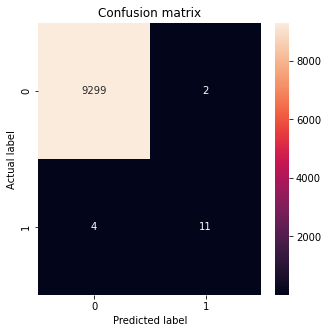

In [18]:
utils.plot_cm(Y_val, history["clf_0"]["y_hat_val"], "RFC")

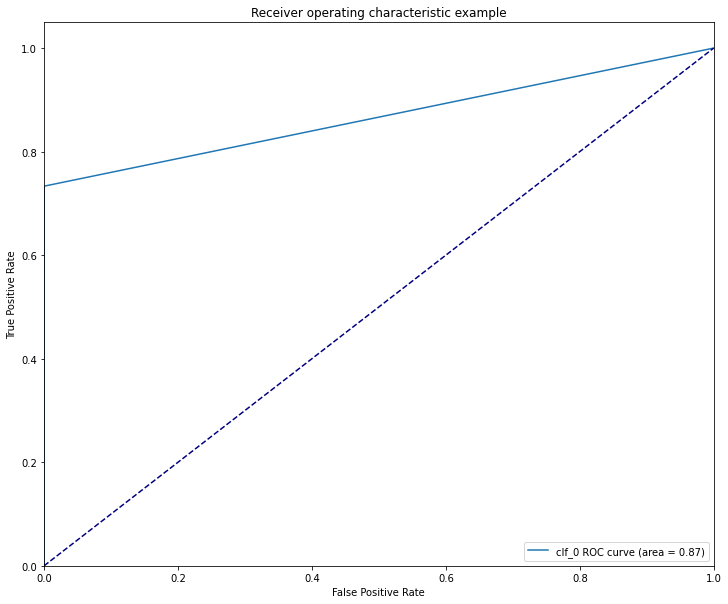

In [19]:
utils.plot_roc_auc_curve(history)

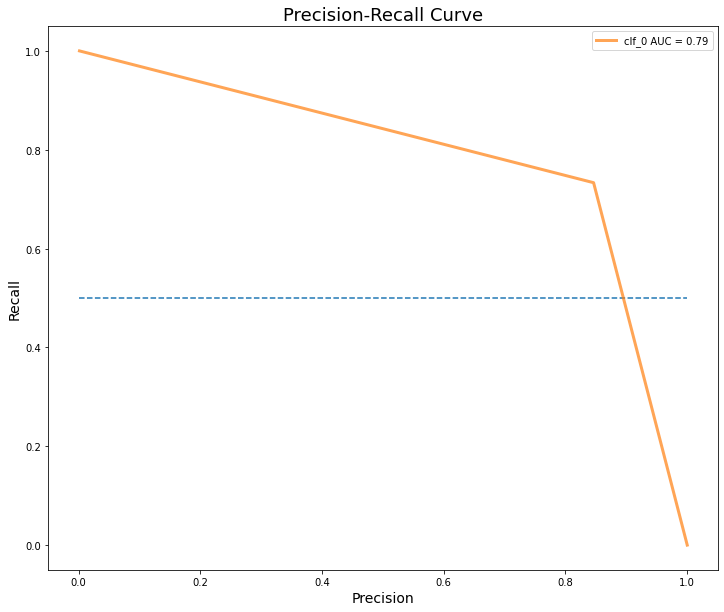

In [20]:
utils.plot_pr_curve(history)

# Testing

In [21]:
X_test_pack = (None, X_test)
Y_test_pack = (None, Y_test)

history_test = utils.compare_models(X_test_pack, Y_test_pack, baseline)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s


ROC AUC score val: 0.9
PR AUC score val: 0.9001594048884166


[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.2s finished


Test


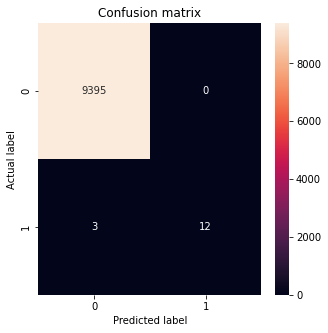

In [22]:
utils.plot_cm(Y_test, history_test["clf_0"]["y_hat_test"], "Test")

# K-fold cross-validation

In [23]:
indices_split, (X_test, Y_test) = utils.split_data(X, Y,test_size=0.05,kfold=10, random_state=RANDOM_STATE)

for key, value in indices_split.items():
    
    print(f"{key} size train: {len(value[0])}, val: {len(value[1])}")

fold_0 size train: 804499, val: 89389
fold_1 size train: 804499, val: 89389
fold_2 size train: 804499, val: 89389
fold_3 size train: 804499, val: 89389
fold_4 size train: 804499, val: 89389
fold_5 size train: 804499, val: 89389
fold_6 size train: 804499, val: 89389
fold_7 size train: 804499, val: 89389
fold_8 size train: 804500, val: 89388
fold_9 size train: 804500, val: 89388


In [25]:
clfs = utils.train_model(X, Y, indices_split=indices_split)

Training clf 0


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   50.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  5.3min finished


Training clf 1


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   30.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  4.0min finished


Training clf 2


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  3.8min finished


Training clf 3


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  3.8min finished


Training clf 4


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   25.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  3.8min finished


Training clf 5


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   25.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  3.8min finished


Training clf 6


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  3.8min finished


Training clf 7


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  3.8min finished


Training clf 8


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   25.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  3.8min finished


Training clf 9


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  3.8min finished


In [26]:
history = utils.compare_models(X, Y, clfs, indices_split)


 Evaluating the model clf_0


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   10.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.3s finished


F1 score - Train: 0.9998021812790762 / val: 0.9999336392731292
ROC AUC score - Train: 0.9764920816986343 / val: 0.9999663903204123
PR AUC score - val: 0.9777777777777779

 Evaluating the model clf_1


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   10.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


F1 score - Train: 0.9998046106624574 / val: 0.9999115606531478
ROC AUC score - Train: 0.9758680288233957 / val: 0.9999551690128217
PR AUC score - val: 0.976878612716763

 Evaluating the model clf_2


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   10.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.3s finished


F1 score - Train: 0.9998084078041374 / val: 0.9998779978257433
ROC AUC score - Train: 0.9773473491249098 / val: 0.9894656695745822
PR AUC score - val: 0.9625002430716781

 Evaluating the model clf_3


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.3s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   10.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.3s finished


F1 score - Train: 0.9998082061762125 / val: 0.9998791148213294
ROC AUC score - Train: 0.976134445689962 / val: 0.9999383677540089
PR AUC score - val: 0.9658385093167702

 Evaluating the model clf_4


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   10.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.3s finished


F1 score - Train: 0.9998094134387422 / val: 0.9998682215420897
ROC AUC score - Train: 0.9760123392298293 / val: 0.9999327595481441
PR AUC score - val: 0.9644970414201184

 Evaluating the model clf_5


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   10.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.3s finished


F1 score - Train: 0.9998167072962822 / val: 0.9998034183674015
ROC AUC score - Train: 0.9763314693549553 / val: 0.9967797394905243
PR AUC score - val: 0.9485851389839506

 Evaluating the model clf_6


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   10.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.3s finished


F1 score - Train: 0.9998058788456972 / val: 0.9999003921484321
ROC AUC score - Train: 0.9763258663746678 / val: 0.9968301715249527
PR AUC score - val: 0.972928497721022

 Evaluating the model clf_7


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.7s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   11.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.6s finished


F1 score - Train: 0.9998082725751753 / val: 0.9998787789826554
ROC AUC score - Train: 0.9765686205787788 / val: 0.9965193156625308
PR AUC score - val: 0.9643228714790296

 Evaluating the model clf_8


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   10.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


F1 score - Train: 0.9998009931930018 / val: 0.9999445373299088
ROC AUC score - Train: 0.9762176060978939 / val: 0.9999719865983886
PR AUC score - val: 0.9833333333333334

 Evaluating the model clf_9


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   10.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.6s


F1 score - Train: 0.9998884854882778 / val: 0.999095938314148
ROC AUC score - Train: 0.9977330608896174 / val: 0.8155353420450979
PR AUC score - val: 0.7475789535508122


[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.3s finished


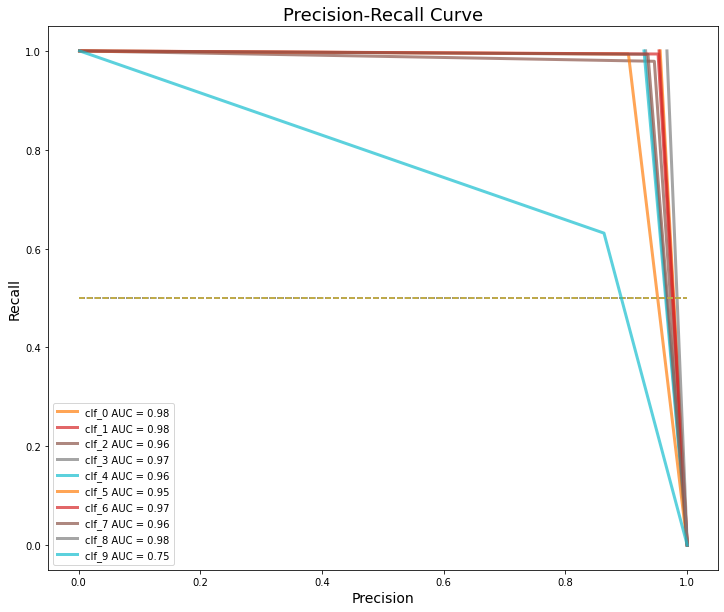

In [27]:
utils.plot_pr_curve(history)

In [30]:
X_test_pack = (None, X_test)
Y_test_pack = (None, Y_test)

for clf in clfs.values():
    history_test2 = utils.compare_models(X_test_pack, Y_test_pack, clf)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


ROC AUC score val: 0.9544177134341069
PR AUC score val: 0.8814491165295524


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


ROC AUC score val: 0.9544177134341069
PR AUC score val: 0.8814491165295524


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


ROC AUC score val: 0.9544177134341069
PR AUC score val: 0.8814491165295524


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


ROC AUC score val: 0.9544177134341069
PR AUC score val: 0.8814491165295524


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


ROC AUC score val: 0.9544177134341069
PR AUC score val: 0.8814491165295524


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


ROC AUC score val: 0.9544177134341069
PR AUC score val: 0.8814491165295524


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


ROC AUC score val: 0.9544177134341069
PR AUC score val: 0.8814491165295524


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


ROC AUC score val: 0.9544177134341069
PR AUC score val: 0.8814491165295524


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


ROC AUC score val: 0.9544177134341069
PR AUC score val: 0.8814491165295524


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.5s


ROC AUC score val: 0.9544177134341069
PR AUC score val: 0.8814491165295524


[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    1.0s finished


In [32]:
from joblib import dump

dump(clfs["clf_0"], 'baseline_rfc.joblib') 

['baseline_rfc.joblib']